In [2]:
%load_ext autoreload
%autoreload 2

import sys
# change this to suit your path
sys.path.append('/home/guillaume/Python/kt_simul/')
#from kt_simul.smp_spindle.smp_spindle import SympySpindle, parameters


import IPython.display as disp
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Visualisation using openscad

This has the advangtage of being simple to use

```python
import solid as solid
import tempfile
solid.use('spindle.scad')
spindle_length = 4
ch_pos = [-0.4, 0.1, 1]
stretch = 0.3
ch_theta = 30
ch_phi = 10

scad_spindle = (spindle_midzone(spindle_length) +
                chromosome(ch_pos, stretch, ch_theta, ch_phi))
def show_scad(scad_spindle, img_name='spindle_scad.png'):
    if os.path.isfile(img_name):
        os.remove(img_name)
    with tempfile.NamedTemporaryFile('w', suffix='.scad') as tmp_scad:
        solid.scad_render_to_file(scad_spindle, tmp_scad.name)
        os.system('openscad -o {} {}'.format(img_name, tmp_scad.name))
    return disp.Image(img_name)
show_scad(scad_spindle)
```

### Model description

We're looking at a simple mechanical system

![3D spindle](3d_spindle.svg)



#### Points and coordiantes

Point is the physical location of an element.

In the method we use to write the equations of motion of the system, we use what is caled **generalized coordinates** and **generalized speeds**. The generic letter for a gen. coordinate is **q** and **u** for the speeds. Those are the quantities marked in red on the sketch.

As a starting point to a 3D description of the spindle, we assume that the chromosomes are 'aligned', thus there is a single extra reference frame, noted $\mathbf{C}$, for each chromosome.




### Parameters 

In [5]:
from kt_simul.core.parameters import get_default_paramtree

In [10]:
params = get_default_paramtree().relative_dic

## Spindle class instanciation



$$\frac{d}{dt}\left(d_{ij}\frac{r_{ij}}{d_{ij}}\right)$$

In [11]:
import pandas as pd
import numpy as np

In [17]:
pd.MultiIndex(levels=[[],[]], labels=[[],[]], names=['srce', 'trgt'])

MultiIndex(levels=[[], []],
           labels=[[], []],
           names=['srce', 'trgt'])

In [51]:
coords = ['x', 'y', 'z']
speed_coords = ['v'+c for c in coords]
dcoords = ['d'+c for c in coords]
ucoords = ['u'+c for c in coords]


point_cols = coords + speed_coords
link_cols = dcoords + ucoords + ['length',]

def _to_3d(df):
    df_3d = np.asarray(df).repeat(3).reshape((df.size, 3))
    return df_3d


class Structure:
    
    def __init__(self, name):
        self.name = name
        self.points = {}
        self.links = {}
        self.point_df = pd.DataFrame(columns=point_cols)
        _link_idx = pd.MultiIndex(levels=[[],[]], 
                                  labels=[[],[]],
                                  names=['srce', 'trgt'])
        self.link_df = pd.DataFrame(columns=link_cols, index=_link_idx)
        self.point_hist = 
        
    def add_point(self, idx, pos0=None, speed0=None):
        
        if pos0 is None:
            pos0 = np.zeros(len(coords))
        if speed0 is None:
            speed0 = np.zeros(len(coords))
        
        state = np.concatenate((pos0, speed0)).reshape((1, len(coords)*2))
        self.point_df = self.point_df.append(pd.DataFrame(index=[idx,],
                                                          data=state,
                                                          columns=point_cols))
        p = Point(idx, self)
        self.points[idx] = p
        return p
    
    def add_link(self, point_i, point_j):
        
        state = np.zeros((1, len(self.link_df.columns)))
        self.link_df = self.link_df.append(pd.DataFrame(index=[(point_i.idx, point_j.idx)],
                                                        data=state,
                                                        columns=self.link_df.columns))
        link = Link(point_i, point_j, self)
        self.links[(point_i.idx, point_j.idx)] = link
        return link

    @property
    def srce_idx(self):
        return self.link_df.index.get_level_values('srce')
    
    @property
    def trgt_idx(self):
        return spindle.link_df.index.get_level_values('trgt')

    
    def update_geometry(self):
        
        for c in coords:
            self.link_df['d'+c] = (self.point_df[c].loc[self.trgt_idx].values 
                                   - self.point_df[c].loc[self.srce_idx].values)
        
        self.link_df['length'] = (self.link_df[dcoords]**2).sum(axis=1)**0.5
        self.link_df[ucoords] = self.link_df[dcoords] / _to_3d(self.link_df['length'])
        for link in self.links.values():
            link.update_outer()
    
class Point:
    
    def __init__(self, idx, structure):
        
        self.idx = idx
        self.idxs = slice(idx*3, idx*3 + 3)

        self.structure = structure
        
    @property
    def pos(self):
        return self.structure.point_df.loc[self.idx, coords]

    @property
    def speed(self):
        return self.structure.point_df.loc[self.idx, speed_coords]
    
            
class Link:
    
    def __init__(self, point_i, point_j, structure):

        self.structure = structure
        
        self.point_i = point_i
        self.point_j = point_j
        idx_i = point_i.idx
        idx_j = point_j.idx
      
        self.idx = (idx_i, idx_j)
        self.idxs_i = point_i.idxs
        self.idxs_j = point_j.idxs

        self.idxs_ii = (self.idxs_i, self.idxs_i)
        self.idxs_ij = (self.idxs_i, self.idxs_j)
        self.idxs_jj = (self.idxs_j, self.idxs_j)
        self.idxs_ji = (self.idxs_j, self.idxs_i)
        
    @property
    def data(self):
        return self.structure.link_df.loc[self.idx]
    
    @property
    def dcoords(self):
        return self.structure.link_df.loc[self.idx, dcoords]

    @property
    def length(self):
        return self.structure.link_df.loc[self.idx, 'length']

    @property
    def speed(self):
        return self.structure.link_df.loc[self.idx, dspeeds]

    @property
    def unit(self):
        return self.structure.link_df.loc[self.idx, ucoords]
    
    def update_outer(self):
        self.outer = np.outer(self.unit, self.unit)
    
    


In [86]:
class Model:
    
    def __init__(self, structure, dt=1):
        
        self.structure = structure
        self.dt = dt
        self.dim = len(self.structure.points)
        self.Amat = np.zeros((self.dim * 3, self.dim * 3))
        self.Bvect = np.zeros(self.dim * 3)

    def solve(self):
        speeds = np.linalg.solve(self.Amat, -self.Bvect)
        for i, c in enumerate(coords):
            self.structure.point_df['v'+c] = speeds[i::3]
            self.structure.point_df[c] += speeds[i::3] * dt
        self.structure.update_geometry()
        
def viscous(model, point, mu):
    
    mat = - np.eye(3) * mu
    model.Amat[point.idxs, point.idxs] += - np.eye(3) * mu

def dashpot(model, link, mu):

 
    block = mu * link.outer
    model.Amat[link.idxs_ii] += block
    model.Amat[link.idxs_ij] -= block
    model.Amat[link.idxs_jj] -= block
    model.Amat[link.idxs_ji] += block

def spring(model, link, kappa, d_eq=0):

    idx_i, idx_j = link.idx
    idxs_i = slice(idx_i*3, idx_i*3 + 3)
    idxs_j = slice(idx_j*3, idx_j*3 + 3)
    
    F = -kappa * (link.length -d_eq) * link.unit
    model.Bvect[link.idxs_i] += F
    model.Bvect[link.idxs_j] -= F
    
def dampedspring(model, link, mu, kappa, d_eq=0):

    dashpot(model, link, mu)
    spring(model, link, kappa, d_eq)

def contraction(model, link, F):
    
    model.Bvect[link.idxs_i] += F * link.unit
    model.Bvect[link.idxs_j] -= F * link.unit
    
def linear_fv(model, link, F_stall, v_max, gamma=-1):

    dashpot(model, link, F_stall / v_max)
    contraction(model, link, gamma * F_stall)
    

In [87]:
spindle = Structure('df_spindle_1_1')

spbL = spindle.add_point(0, [-1, 0, 0])
spbR = spindle.add_point(1, [1, 0, 0])
cenA = spindle.add_point(2, [-0.2, 0, 0])
cenB = spindle.add_point(3, [0.2, 0, 0])

psA = spindle.add_point(4, [-0.3, 0, 0])
psB = spindle.add_point(5, [0.3, 0, 0])

mz = spindle.add_link(spbL, spbR)
chromatin = spindle.add_link(cenA, cenB)
ktA = spindle.add_link(cenA, psA)
ktB = spindle.add_link(cenB, psB)

spindle.update_geometry()

metaphase = Model(spindle)

In [88]:
params['muco'] = 1.

for cen in (cenA, cenB):
    viscous(metaphase, cen, params['muc'])

for spb in (spbR, spbL):
    viscous(metaphase, spb, params['mus'])

dampedspring(metaphase, chromatin, 
             params['muc'],
             params['kappa_c'],
             params['d0'])

for kt in (ktA, ktB):
    dampedspring(metaphase, kt, 
                 params['muk'],
                 params['kappa_k'],
                 params['d0'])

linear_fv(metaphase, mz, 
          params['Fmz'],
          params['Vmz'],
          gamma=1)

In [89]:
metaphase.Bvect

array([ 10.  ,   0.  ,   0.  , -10.  ,   0.  ,   0.  ,  -1.15,   0.  ,
         0.  ,   1.15,   0.  ,   0.  ,  -0.25,   0.  ,   0.  ,   0.25,
         0.  ,   0.  ])

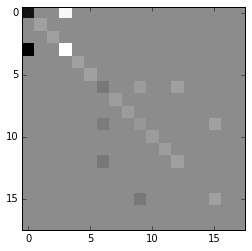

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(metaphase.Amat, interpolation='nearest', cmap='Greys')

In [91]:
metaphase.solve()

LinAlgError: Singular matrix

In [77]:
spindle.point_df

,x,y,z,vx,vy,vz
0,-1.0,0,0,0,0,0
1,1.0,0,0,0,0,0
2,-0.2,0,0,0,0,0
3,0.2,0,0,0,0,0
4,-0.3,0,0,0,0,0
5,0.3,0,0,0,0,0


In [76]:
len(spindle.points)

6

In [50]:
chromatin.get_outer()

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [40]:

spindle.point_df

,x,y,z,vx,vy,vz
0,-1.0,0,0,0,0,0
1,1.0,0,0,0,0,0
2,-0.2,0,0,0,0,0
3,0.2,0,0,0,0,0
4,-0.3,0,0,0,0,0
5,0.3,0,0,0,0,0


In [44]:

spindle.link_df

,,dx,dy,dz,ux,uy,uz,length
srce,trgt,,,,,,,
0,1,2.0,0,0,1,0,0,2.0
2,3,0.4,0,0,1,0,0,0.4


In [34]:
cenA

In [43]:
from kt_simul.io.parameters_io import ParamTree
from kt_simul.core.simul_spindle import Metaphase